# CV_PROJECT - 2_PART C:

## Part C 
**• DOMAIN:** Face Recognition

**• CONTEXT:** Company X intends to build a face identification model to recognise human faces.

**• DATA DESCRIPTION:** The dataset comprises of images and its mask where there is a human face.

**• PROJECT OBJECTIVE:** Face Aligned Face Dataset from Pinterest. This dataset contains 10,770 images for 100 people. All images are taken from 'Pinterest' and aligned using dlib library. Some data samples

 
## 1. Unzip, read and Load data(‘PINS.zip’) into session. 
## 2. Write function to create metadata of the image.
Hint: Metadata means derived information from the available data which can be useful for particular problem statement.
## 3. Write a loop to iterate through each and every image and create metadata for all the images. 
## 4. Generate Embeddings vectors on the each face in the dataset.
Hint: Use ‘vgg_face_weights.h5’
## 5. Build distance metrics for identifying the distance between two similar and dissimilar images. 
## 6. Use PCA for dimensionality reduction. 
## 7. Build an SVM classifier in order to map each image to its right person.
## 8. Import and display the the test images.
Hint: ‘Benedict Cumberbatch9.jpg’ and ‘Dwayne Johnson4.jpg’ are the test images.
## 9. Use the trained SVM model to predict the face on both test images.

In [1]:
#Import necessary libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D, MaxPooling2D, MaxPool2D, GlobalMaxPooling2D, BatchNormalization
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, auc,classification_report, roc_curve
from tensorflow.keras import optimizers
from keras import regularizers
from keras.optimizers import SGD
from tensorflow.keras import backend
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras import optimizers
from keras.utils import np_utils
from sklearn.preprocessing import StandardScaler
from glob import glob
import cv2
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import ZeroPadding2D
from tensorflow.keras.layers import Softmax,Flatten,Activation
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
import tensorflow.keras.backend as K

In [2]:
import tensorflow
tensorflow.__version__

'2.12.0'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Unzip, read and Load data(‘PINS.zip’) into session.

In [4]:
# Extract the ZIP file
file_path = "/content/drive/My Drive/CV_FILES/PINS.zip"

from zipfile import ZipFile
with ZipFile(file_path,'r') as zip:
  zip.extractall(path='/content/drive/My Drive/CV_FILES/CV Project-2-Face Recognition')

In [5]:
import os
path = '/content/drive/My Drive/CV_FILES/CV Project-2-Face Recognition/PINS'

- The PINS.zip file is extracted and stored to 'CV Project-2-Face Recognition' folder.

## 2. Write function to create metadata of the image.
Hint: Metadata means derived information from the available data which can be useful for particular problem statement.

In [6]:
# Create empty lists to store the data
img_name = []
img_class = []
img = []

# Loop over all the classes in the data directory
for class_name in os.listdir(path):
    class_dir = os.path.join(path, class_name)
    if os.path.isdir(class_dir):
        # Loop over all the images in the class directory
        for img_file in os.listdir(class_dir):
            if img_file.endswith('.jpg'):
                img_path = os.path.join(class_dir, img_file)
                img_name.append(img_file)
                img_class.append(class_name)
                img.append(cv2.imread(img_path))

# Create a DataFrame from the data
df = pd.DataFrame({'img_name': img_name, 'class': img_class, 'img': img})

In [7]:
df.head()

,img_name,class,img
0,Aaron Paul27_281.jpg,pins_Aaron Paul,"[[[232, 235, 239], [231, 234, 238], [229, 232,..."
1,Aaron Paul58_209.jpg,pins_Aaron Paul,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
2,Aaron Paul55_274.jpg,pins_Aaron Paul,"[[[26, 52, 64], [25, 51, 63], [28, 52, 64], [2..."
3,Aaron Paul3_242.jpg,pins_Aaron Paul,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
4,Aaron Paul119_219.jpg,pins_Aaron Paul,"[[[63, 63, 63], [62, 62, 62], [69, 69, 69], [7..."


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10770 entries, 0 to 10769
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   img_name  10770 non-null  object
 1   class     10770 non-null  object
 2   img       10770 non-null  object
dtypes: object(3)
memory usage: 252.5+ KB


In [9]:
# resize image
def resize_images(img):

  img = np.array(img).astype(np.uint8)
  #print(img.dtype)
  res = cv2.resize(img,(224,224), interpolation = cv2.INTER_CUBIC)
  return res

#save resized images into images.
images = [resize_images(img) for img in img]

In [10]:
images[0].shape

(224, 224, 3)

In [11]:
#see number of images in each label
images = np.array(images)
classes = np.array(img_class)
print("images shape: ", images.shape)
print("classes shape: ", classes.shape)

images shape:  (10770, 224, 224, 3)
classes shape:  (10770,)


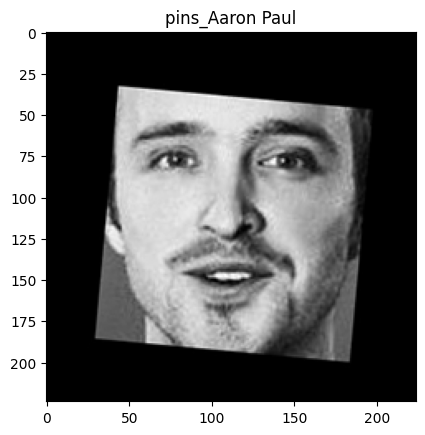

In [12]:
plt.title(classes[10])
plt.imshow(images[10]);

## 3. Write a loop to iterate through each and every image and create metadata for all the images. 

In [13]:
class IdentityMetadata():
    def __init__(self, base, name, file):
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

metadata = load_metadata(path)

## 4. Generate Embeddings vectors on the each face in the dataset.
Hint: Use ‘vgg_face_weights.h5’

In [14]:
# VGG_face_weights path
weights_file = '/content/drive/My Drive/CV_FILES/CV Project-2-Face Recognition/vgg_face_weights.h5'

In [15]:
# Define VGG_FACE_MODEL architecture

model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))	
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))


In [16]:
# Load VGG Face model weights

model.load_weights(weights_file)

In [17]:
from tensorflow.keras.models import Model

vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

In [18]:
# Get embedding vector for first image in the metadata using the pre-trained model

img_path = metadata[0].image_path()

def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

img = load_image(img_path)


# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
img = (img / 255.).astype(np.float32)

img = cv2.resize(img, dsize = (224,224))
print(img.shape)

# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape 

embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
print(embedding_vector.shape)

(224, 224, 3)
1/1 [==============================] - 9s 9s/step
(2622,)


In [19]:
embeddings = np.zeros((metadata.shape[0], 2622))
k = 0
for i, m in enumerate(metadata):
    try:
        img = load_image(m.image_path())
        if k % 500 == 0:
            print(k)
        # scale RGB values to interval [0,1]
        img = cv2.resize(img, dsize = (224,224))
        img = (img / 255.).astype(np.float32)
        # obtain embedding vector for image
        embeddings[i] = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
        k += 1
    except Exception as e:
        print(str(e))
        print(i,m)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 23ms/step
6000
1/1 [==============================] - 0s 19ms/step
6500
1/1 [==============================] - 0s 18ms/step
7000
1/1 [==============================] - 0s 19ms/step
7500
1/1 [==============================] - 0s 24ms/step
8000
1/1 [==============================] - 0s 28ms/step
8500
1/1 [==============================] - 0s 19ms/step
9000
1/1 [==============================] - 0s 21ms/step
9500
1/1 [==============================] - 0s 23ms/step
10000
1/1 [==============================] - 0s 20ms/step
10500
1/1 [==============================] - 0s 20ms/step


## 5. Build distance metrics for identifying the distance between two similar and dissimilar images. 

In [20]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

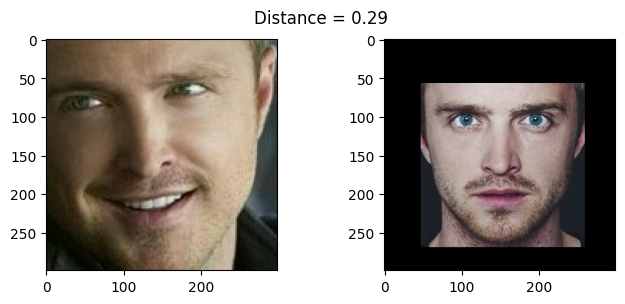

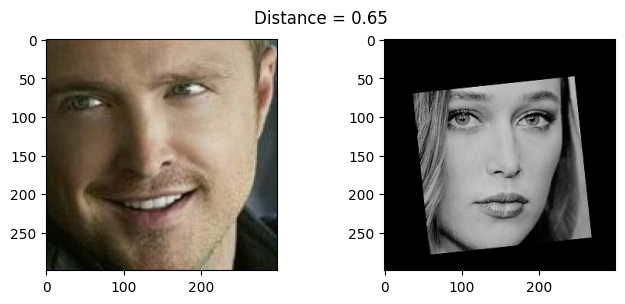

In [21]:
def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

show_pair(2, 3)
show_pair(2, 180)

In [22]:
train_idx = np.arange(metadata.shape[0]) % 9 != 0
test_idx = np.arange(metadata.shape[0]) % 9 == 0

# one half as train examples of 10 identities
X_train = embeddings[train_idx]
# another half as test examples of 10 identities
X_test = embeddings[test_idx]

targets = np.array([m.name for m in metadata])
y_train = targets[train_idx]
y_test = targets[test_idx]

In [23]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

# Numerical encoding of identities
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

## 6. Use PCA for dimensionality reduction. 

In [24]:
from sklearn.decomposition import PCA

pca = PCA(n_components=128, svd_solver='randomized', whiten=True)

X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

## 7. Build an SVM classifier in order to map each image to its right person.

In [25]:
from sklearn.svm import SVC

clf = SVC(kernel='rbf', class_weight=None , C=10000000, gamma='auto')
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.9598997493734336

In [50]:
# Predict
y_pred = clf.predict(X_test)

In [51]:

names = [name.split('_')[1].title().strip() for name in df["class"]]

# Classification Report
print('Classification Report: \n{}'.format(classification_report(y_test, y_pred, target_names = np.unique(names))))

Classification Report: 
                          precision    recall  f1-score   support

              Aaron Paul       1.00      1.00      1.00        10
      Alexandra Daddario       1.00      0.90      0.95        10
            Alvaro Morte       1.00      0.93      0.96        14
Alycia Debnam Carey Face       1.00      1.00      1.00        12
             Amanda Crew       1.00      1.00      1.00         7
          Amaury Nolasco       1.00      1.00      1.00         9
        Amber Heard Face       1.00      1.00      1.00         7
               Anna Gunn       0.93      1.00      0.97        14
           Anne Hathaway       0.88      1.00      0.93        14
     Barbara Palvin Face       1.00      0.89      0.94         9
      Bellamy Blake Face       1.00      0.93      0.96        14
    Benedict Cumberbatch       1.00      1.00      1.00        12
            Betsy Brandt       1.00      1.00      1.00        10
              Bill Gates       0.91      1.00      

In [52]:
# Standarize features
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

# Encode labels
en = LabelEncoder()

In [53]:
def sample_img_plot(sample_idx):
  # Load image for sample_idx from test data
  sample_img = load_image(metadata[test_idx][sample_idx].image_path())
  # Get actual name
  actual_name = metadata[test_idx][sample_idx].name.split('_')[-1].title().strip()
  # Normalizing pixel values
  sample_img = (sample_img/255.).astype(np.float32)
  # Resize
  sample_img = cv2.resize(sample_img, (224, 224))

  # Obtain embedding vector for sample image
  embedding = vgg_face_descriptor.predict(np.expand_dims(sample_img, axis = 0))[0]
  # Scaled the vector and reshape
  embedding_scaled = sc.transform(embedding.reshape(1, -1))
  # Predict
  sample_pred = clf.predict(pca(n_components=128).transform(embedding_scaled))
  # Transform back
  pred_name = en.inverse_transform(sample_pred)[0].split('_')[-1].title().strip()
  return sample_img, actual_name, pred_name

## 8. Import and display the the test images.
Hint: ‘Benedict Cumberbatch9.jpg’ and ‘Dwayne Johnson4.jpg’ are the test images.

In [26]:
test_image1_path = '/content/drive/My Drive/CV_FILES/CV Project-2-Face Recognition/Predict_Images/Benedict Cumberbatch9.jpg'

test_image2_path = '/content/drive/My Drive/CV_FILES/CV Project-2-Face Recognition/Predict_Images/Dwayne Johnson4.jpg'

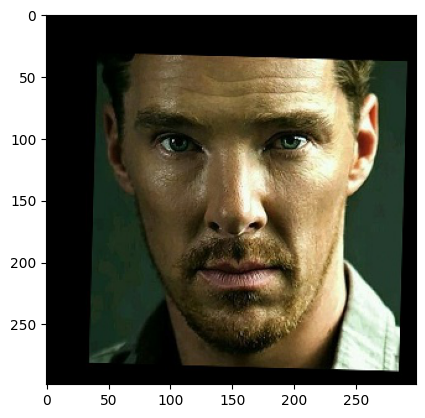

In [27]:
image1 = plt.imread(test_image1_path)
plt.imshow(image1);

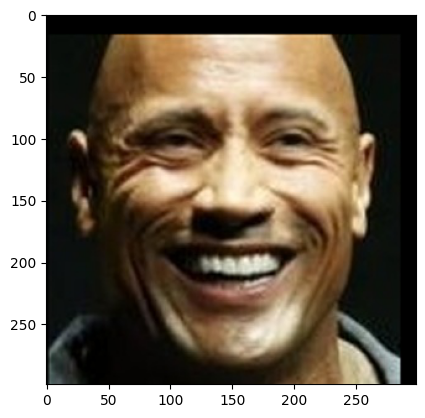

In [28]:
image2 = plt.imread(test_image2_path)
plt.imshow(image2);

In [29]:
image1_resized = resize_images(image1)
image1_resized = np.array(image1_resized)

In [30]:
image1_resized.shape

(224, 224, 3)

## 9. Use the trained SVM model to predict the face on both test images.

ValueError: ignored

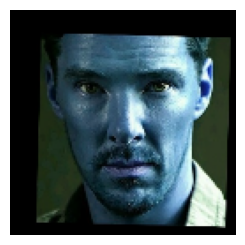

In [31]:
# Load the test images
img1 = load_image(test_image1_path)
img2 = load_image(test_image2_path)

# Resize the images to 128 x 128
img1 = cv2.resize(img1, (128, 128))
img2 = cv2.resize(img2, (128, 128))

# Preprocess the images to have pixel values in the range [0, 1]
img1 = img1.astype('float32') / 255.0
img2 = img2.astype('float32') / 255.0

# Use the trained SVM classifier to predict the person in each test image
for i, img in enumerate([img1, img2]):
    # Display the test image
    plt.subplot(1, 2, i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    # Use the trained SVM classifier to predict the person in the test image
    img_flat = img.flatten()[:16384].reshape(1, -1)
    prediction = clf.predict(img_flat)
    identity = encoder.inverse_transform(prediction)[0]

    # Add the predicted identity to the title of the subplot
    plt.title(identity)

plt.show()


In [32]:
def load_metadata1(path):
    metadata1 = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            metadata1.append(IdentityMetadata(path, i, f))
    return np.array(metadata1)

In [33]:
path1 = '/content/drive/My Drive/CV_FILES/CV Project-2-Face Recognition/Predict_Images'
metadata1 = load_metadata1(path1)

In [34]:
test_idx1 = np.arange(metadata1.shape[0]) % 9 == 0

embeddings1 = np.zeros((metadata1.shape[0], 2622))
X_test1 = embeddings1[test_idx1]

In [35]:
X_test_1 = X_test1.reshape(1, -1)
X_test_1 = X_test_1.reshape((X_test_1.shape[0], -1))

In [36]:
example_prediction = clf.predict([X_test_1])
example_identity = encoder.inverse_transform(example_prediction)[0]

plt.imshow(image1)
plt.title(example_identity);

ValueError: ignored

# PART C IS OVER